# 01 — LinkedIn Lead Scoring: Data Preparation

**Purpose**: Prepare LinkedIn contact list data for binary classification (invite acceptance prediction).

**MLflow Integration**: All data preparation steps are tracked in MLflow from the start.

**Workflow**:
1. Setup MLflow experiment
2. Load raw data from LemList export
3. Create binary labels (engaged vs not engaged)
4. Assess data quality
5. Select modeling features
6. Exploratory analysis
7. Save cleaned dataset

**Output**: Clean labeled dataset ready for modeling (tracked in MLflow)

## 0. Setup & Imports

In [1]:
# Auto-reload modules during development
%load_ext autoreload
%autoreload 2

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import os


# MLflow setup - REQUIRED from the start!
from linkedin_lead_scoring.data.utils_data import setup_mlflow

# Import helper functions
from linkedin_lead_scoring.data.utils_data import (
    load_linkedin_csv,
    standardize_columns,
    create_engagement_labels,
    select_modeling_features,
    assess_missingness,
    value_frequencies,
    engagement_rate_by_category,
    suggest_correlated_features,
    split_feature_types,
    log_data_profile
)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Imports complete")

✓ Imports complete


In [2]:
import mlflow
from linkedin_lead_scoring.data.utils_data import find_project_root

  # Check current tracking URI
print(f"Current tracking URI: {mlflow.get_tracking_uri()}")

  # Check where project root is detected
project_root = find_project_root()
print(f"Detected project root: {project_root}")
print(f"Expected mlruns location: {project_root / 'mlruns'}")

  # Check if experiment exists
exp = mlflow.get_experiment_by_name("linkedin-lead-scoring")
if exp:
    print(f"\nExperiment found!")
    print(f"  ID: {exp.experiment_id}")
    print(f"  Artifact location: {exp.artifact_location}")
else:
    print("\nNo experiment found yet")

Current tracking URI: sqlite:///mlflow.db
Detected project root: /Users/ghislaindelabie/Projets dév/Formation OC/OC6 - Initiez-vous au MLOps/oc6-linkedin-lead-scoring
Expected mlruns location: /Users/ghislaindelabie/Projets dév/Formation OC/OC6 - Initiez-vous au MLOps/oc6-linkedin-lead-scoring/mlruns


2025/12/12 11:29:41 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/12 11:29:41 INFO mlflow.store.db.utils: Updating database tables
2025/12/12 11:29:41 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/12 11:29:41 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/12 11:29:41 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/12 11:29:41 INFO alembic.runtime.migration: Will assume non-transactional DDL.



Experiment found!
  ID: 1
  Artifact location: /Users/ghislaindelabie/Projets dév/Formation OC/OC6 - Initiez-vous au MLOps/oc6-linkedin-lead-scoring/notebooks/mlruns/1


## 1. MLflow Experiment Setup

**CRITICAL**: Initialize MLflow before any data operations!

In [3]:
# Initialize MLflow experiment
experiment_id = setup_mlflow(experiment_name="linkedin-lead-scoring")

# Start a run for data preparation
mlflow.start_run(run_name="data_preparation_v1")

# Log notebook metadata
mlflow.log_param("notebook", "01_linkedin_data_prep.ipynb")
mlflow.log_param("purpose", "data_preparation")
mlflow.log_param("author", "Ghislain de Labie")

print(f"✓ MLflow run started: {mlflow.active_run().info.run_id}")
print(f"✓ View results: http://localhost:5000")

✓ MLflow tracking configured
  Project root: /Users/ghislaindelabie/Projets dév/Formation OC/OC6 - Initiez-vous au MLOps/oc6-linkedin-lead-scoring
  Tracking URI: file:///Users/ghislaindelabie/Projets%20de%CC%81v/Formation%20OC/OC6%20-%20Initiez-vous%20au%20MLOps/oc6-linkedin-lead-scoring/mlruns
✓ MLflow experiment: 'linkedin-lead-scoring'
  Experiment ID: 796258469850849262
  Artifact location: file:///Users/ghislaindelabie/Projets%20de%CC%81v/Formation%20OC/OC6%20-%20Initiez-vous%20au%20MLOps/oc6-linkedin-lead-scoring/mlruns/796258469850849262
✓ MLflow run started: 5e2bb52c26b34470bbb1a7864a8f9eae
✓ View results: http://localhost:5000


/opt/anaconda3/envs/oc6/lib/python3.11/site-packages/mlflow/tracking/_tracking_service/utils.py:177: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri, store_uri)


## 2. Load Raw Data

Load LinkedIn contact list CSV from LemList export (automatically logged to MLflow)

In [4]:
# Define data path
data_path = "../data/FR - LinkedIn Followers - Conversation starter.csv"

# Load raw data (logs to MLflow automatically)
raw_df = load_linkedin_csv(data_path, log_to_mlflow=True)

# Quick inspection
print(f"\nShape: {raw_df.shape}")
print(f"\nColumn names:")
print(list(raw_df.columns))

# Display first few rows
raw_df.head(3)

✓ Loaded 477 contacts with 31 columns
✓ Logged raw data profile to MLflow

Shape: (477, 31)

Column names:
['emailStatus', 'email', 'firstName', 'lastName', 'picture', 'phone', 'linkedinUrl', 'timezone', 'companyName', 'companyDomain', 'icebreaker', 'location', 'tagline', 'industry', 'summary', 'languages', 'skills', 'jobTitle', 'companyLinkedinUrl', 'companyDescription', 'companyFoundedOn', 'companyIndustry', 'companyLocation', 'companyPicture', 'companySize', 'companySpecialties', 'companyTagline', 'companyType', 'lastState', 'status', '_id']


,emailStatus,email,firstName,lastName,picture,phone,linkedinUrl,timezone,companyName,companyDomain,icebreaker,location,tagline,industry,summary,languages,skills,jobTitle,companyLinkedinUrl,companyDescription,companyFoundedOn,companyIndustry,companyLocation,companyPicture,companySize,companySpecialties,companyTagline,companyType,lastState,status,_id
0,NaN,NaN,Karim,Mouilek,https://app.lemlist.com/api/files/Files/lip_cb...,NaN,https://www.linkedin.com/in/karim-mouilek,NaN,Slack,slack.com,NaN,"Paris, Île-de-France, France",Lead Solutions Engineer @Slack,Information Technology & Services,Experienced Sales Engineer (18+ years) with a ...,"Arabic, English, French","Vente aux dirigeants, Relations avec les dirig...",Lead Solutions Engineer,https://www.linkedin.com/company/tiny-spec-inc,Slack is on a mission to make people's working...,NaN,Software Development,"San Francisco, US",https://app.lemlist.com/api/files/Files/lip_9f...,1001-5000,NaN,NaN,Public Company,linkedinReplied,done,lea_288jECrHTH3My3n5J
1,NaN,NaN,Pauline,Buche,https://app.lemlist.com/api/files/Files/lip_5a...,NaN,https://www.linkedin.com/in/pauline-buche-b496...,NaN,Mistral AI,mistral.ai,NaN,"Paris, Île-de-France, France","Director, Commercial legal affairs @Mistral AI",Computer Software,NaN,"Anglais, Espagnol, Français","Droit commercial, Rédaction de contrats, Droit...","Director, Commercial legal affairs",https://www.linkedin.com/company/mistralai,Frontier AI. In your hands. \n\nWe believe in ...,2023.0,Software Development,"Paris, FR",https://app.lemlist.com/api/files/Files/lip_d2...,201-500,NaN,Frontier AI. In Your Hands.,Privately Held,linkedinInviteAccepted,done,lea_2CADXtuZnbsHXKpvM
2,NaN,NaN,Louis,F.,https://app.lemlist.com/api/files/Files/lip_36...,NaN,https://www.linkedin.com/in/louis-ferrandez,NaN,NaN,NaN,NaN,"Paris, Île-de-France, France",Driving revenue growth for B2B SaaS Companies,Computer Software,👋🏻 Hello and welcome {{FirstName}} 🤝\n\nTo int...,NaN,"Génération de leads, Growth hacking, Business-...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,linkedinInviteAccepted,inProgress,lea_2TbyuJKpLsW8uWYuj


In [5]:
# Standardize column names (snake_case)
df = standardize_columns(raw_df)

print("✓ Columns standardized")
print(f"Example: {list(df.columns)[:5]}")

✓ Columns standardized
Example: ['emailstatus', 'email', 'firstname', 'lastname', 'picture']


## 3. Create Engagement Labels

**Labeling Logic** (logged to MLflow):
- **Positive (1)**: `lastState == 'linkedinInviteAccepted'`
- **Negative (0)**: `status == 'done' AND lastState != 'linkedinInviteAccepted'`
- **Filtered out**: Everything else (inProgress, reviewed, etc.)

In [6]:
# Check available states before labeling
print("lastState distribution:")
print(df['laststate'].value_counts())
print("\nstatus distribution:")
print(df['status'].value_counts())

lastState distribution:
laststate
linkedinInviteAccepted    198
linkedinInviteDone        138
linkedinReplied           111
reviewed                   19
linkedinInterested         10
manualNotInterested         1
Name: count, dtype: int64

status distribution:
status
done             293
inProgress       154
reviewed          19
interested        10
notInterested      1
Name: count, dtype: int64


In [7]:
# Create labels (automatically logs to MLflow)
labeled_df = create_engagement_labels(df, log_to_mlflow=True)

# Verify label distribution
print("\nFinal label distribution:")
print(labeled_df['engaged'].value_counts())
print(f"\nClass balance: {labeled_df['engaged'].mean():.2%} positive")

✓ Created labels: 477 → 303 contacts
  Positive (engaged=1): 121 contacts (39.9%)
  Negative (engaged=0): 182 contacts (60.1%)
  Filtered out: 174 contacts (unlabeled)
✓ Logged label statistics to MLflow

Final label distribution:
engaged
0    182
1    121
Name: count, dtype: int64

Class balance: 39.93% positive


## 4. Data Quality Assessment

Assess missing values, constant columns, and data quality issues (logged to MLflow)

In [8]:
# Assess data quality (logs metrics to MLflow)
quality = assess_missingness(
    labeled_df,
    quasi_constant_threshold=0.98,
    log_to_mlflow=True
)

# Display quality profile (top 20 by missingness)
print("\nData Quality Profile (top 20 columns by missingness):")
display(quality["profile"].head(20))

# Highlight issues
print(f"\n⚠️  Constant columns: {quality['constant_cols']}")
print(f"⚠️  Quasi-constant columns: {quality['quasi_constant_cols']}")
print(f"⚠️  High missing (≥80%): {quality['high_missing_cols']}")
print(f"⚠️  Moderate missing (40-80%): {quality['moderate_missing_cols']}")

✓ Logged data quality metrics to MLflow

Data Quality Profile (top 20 columns by missingness):


,column,dtype,nunique,n_missing,pct_missing,top_value,top_ratio
0,emailstatus,float64,1,303,1.000000,NaN,1.000000
1,phone,object,1,303,1.000000,NaN,1.000000
2,timezone,float64,1,303,1.000000,NaN,1.000000
3,icebreaker,float64,1,303,1.000000,NaN,1.000000
4,email,object,2,302,0.996700,NaN,0.996700
5,companyspecialties,object,100,194,0.640264,NaN,0.640264
6,companyfoundedon,float64,48,167,0.551155,NaN,0.551155
7,companytagline,object,142,149,0.491749,NaN,0.491749
8,companysize,object,8,133,0.438944,NaN,0.438944
9,companydomain,object,167,121,0.399340,NaN,0.399340



⚠️  Constant columns: ['emailstatus', 'phone', 'timezone', 'icebreaker']
⚠️  Quasi-constant columns: ['email']
⚠️  High missing (≥80%): ['emailstatus', 'email', 'phone', 'timezone', 'icebreaker']
⚠️  Moderate missing (40-80%): ['companyfoundedon', 'companysize', 'companyspecialties', 'companytagline']


## 5. Feature Selection

Remove PII and ID columns, keep only modeling features (logged to MLflow)

In [9]:
# Select features (automatically logs to MLflow)
clean_df, dropped_cols = select_modeling_features(
    labeled_df,
    drop_pii=True,
    drop_ids=True,
    log_to_mlflow=True
)

print(f"\nRemaining columns ({len(clean_df.columns)}):")
print(list(clean_df.columns))

✓ Dropped 12 columns
  Remaining: 20 columns
✓ Logged feature_selected data profile to MLflow
✓ Logged feature selection to MLflow

Remaining columns (20):
['timezone', 'companyname', 'companydomain', 'icebreaker', 'location', 'tagline', 'industry', 'summary', 'languages', 'skills', 'jobtitle', 'companydescription', 'companyfoundedon', 'companyindustry', 'companylocation', 'companysize', 'companyspecialties', 'companytagline', 'companytype', 'engaged']


## 6. Exploratory Data Analysis

Analyze features and their relationship with engagement

In [10]:
# Split numeric vs categorical features
num_features, cat_features = split_feature_types(clean_df, target="engaged")

print(f"Numeric features ({len(num_features)}): {num_features}")
print(f"\nCategorical features ({len(cat_features)}): {cat_features}")

# Log to MLflow
mlflow.log_param("n_numeric_features", len(num_features))
mlflow.log_param("n_categorical_features", len(cat_features))

Numeric features (3): ['timezone', 'icebreaker', 'companyfoundedon']

Categorical features (16): ['companyname', 'companydomain', 'location', 'tagline', 'industry', 'summary', 'languages', 'skills', 'jobtitle', 'companydescription', 'companyindustry', 'companylocation', 'companysize', 'companyspecialties', 'companytagline', 'companytype']


16

In [11]:
# Explore key categorical variables
for col in ['industry', 'jobtitle', 'companysize', 'companylocation']:
    if col in clean_df.columns:
        print(f"\n{'='*60}")
        print(f"{col.upper()} - Top 10 values")
        print(f"{'='*60}")

        # Frequency distribution
        n_unique, freq_df = value_frequencies(clean_df, col)
        display(freq_df.head(10))

        # Engagement rate by category
        if col in clean_df.columns and clean_df[col].notna().sum() > 0:
            eng_rate = engagement_rate_by_category(clean_df, col)
            print(f"\nEngagement rate by {col}:")
            display(eng_rate.head(10))


INDUSTRY - Top 10 values


,industry,Frequency,Percentage
0,Computer Software,56,18.983051
1,Information Technology & Services,41,13.898305
2,Management Consulting,29,9.830508
3,Law Practice,20,6.779661
4,Marketing & Advertising,16,5.423729
5,Internet,13,4.406780
6,Research,10,3.389831
7,Fine Art,6,2.033898
8,Public Relations & Communications,6,2.033898
9,Higher Education,6,2.033898



Engagement rate by industry:


,industry,n,engagement_rate
39,Music,1,1.0
35,Mechanical Or Industrial Engineering,2,1.0
42,Performing Arts,1,1.0
50,Textiles,1,1.0
51,Think Tanks,1,1.0
11,Electrical & Electronic Manufacturing,1,1.0
9,Consumer Goods,1,1.0
6,Computer & Network Security,1,1.0
52,Transportation/Trucking/Railroad,1,1.0
53,Utilities,1,1.0



JOBTITLE - Top 10 values


,jobtitle,Frequency,Percentage
0,Founder,4,1.509434
1,Product Manager,3,1.132075
2,Partner,3,1.132075
3,Member,3,1.132075
4,Senior Product Manager,2,0.754717
5,Mentor,2,0.754717
6,Avocate,2,0.754717
7,Project Manager,2,0.754717
8,Co-fondateur,2,0.754717
9,Lecturer,2,0.754717



Engagement rate by jobtitle:


,jobtitle,n,engagement_rate
123,Développeur Full Stack,1,1.0
139,Founder & Captain,1,1.0
116,Director of strategy and development,1,1.0
119,"Director, International Government Relations, ...",1,1.0
126,EMEA Solution Manager,1,1.0
128,Enterprise Account Executive,1,1.0
132,Expert Lecturer in Cultural Law / Enseignante ...,1,1.0
137,Formatrice,1,1.0
141,Founder NamSor,1,1.0
164,Jury Certigia,1,1.0



COMPANYSIZE - Top 10 values


,companysize,Frequency,Percentage
0,2-10,41,24.117647
1,11-50,36,21.176471
2,1001-5000,28,16.470588
3,51-200,26,15.294118
4,201-500,18,10.588235
5,501-1000,14,8.235294
6,5001-10000,7,4.117647



Engagement rate by companysize:


,companysize,n,engagement_rate
2,2-10,41,0.414634
6,51-200,26,0.384615
3,201-500,18,0.333333
0,1001-5000,28,0.321429
4,5001-10000,7,0.285714
5,501-1000,14,0.285714
1,11-50,36,0.194444



COMPANYLOCATION - Top 10 values


,companylocation,Frequency,Percentage
0,"Paris, FR",89,48.901099
1,"New York, US",7,3.846154
2,"San Francisco, US",6,3.296703
3,"Amsterdam, NL",3,1.648352
4,"Lyon, FR",3,1.648352
5,"Marseille, FR",3,1.648352
6,"Paris La Défense Cedex, FR",2,1.098901
7,"PARIS, FR",2,1.098901
8,"London, GB",2,1.098901
9,"Courbevoie, FR",2,1.098901



Engagement rate by companylocation:


,companylocation,n,engagement_rate
0,"91190, FR",1,1.0
17,"Dole, FR",1,1.0
65,"Villeurbanne, FR",1,1.0
64,"Versailles, FR",1,1.0
62,"Toulouse, FR",1,1.0
50,"Planegg, DE",1,1.0
34,"Milano, IT",1,1.0
26,"La Plaine Saint-Denis, FR",1,1.0
21,"Hangzhou, CN",1,1.0
20,"Grenoble, FR",1,1.0


In [12]:
# Correlation analysis for numeric features
if len(num_features) > 1:
    # Suggest correlated features to drop (logs to MLflow)
    to_drop, corr_pairs = suggest_correlated_features(
        clean_df,
        cols=num_features,
        threshold=0.80,
        protect=[],  # No protected features for now
        return_pairs=True,
        log_to_mlflow=True
    )

    if len(corr_pairs) > 0:
        print("\nHighly correlated feature pairs:")
        display(corr_pairs.head(10))
        print(f"\nSuggested features to drop: {to_drop}")
    else:
        print("✓ No highly correlated features found")
else:
    print("⚠️  Not enough numeric features for correlation analysis")

✓ No highly correlated features found


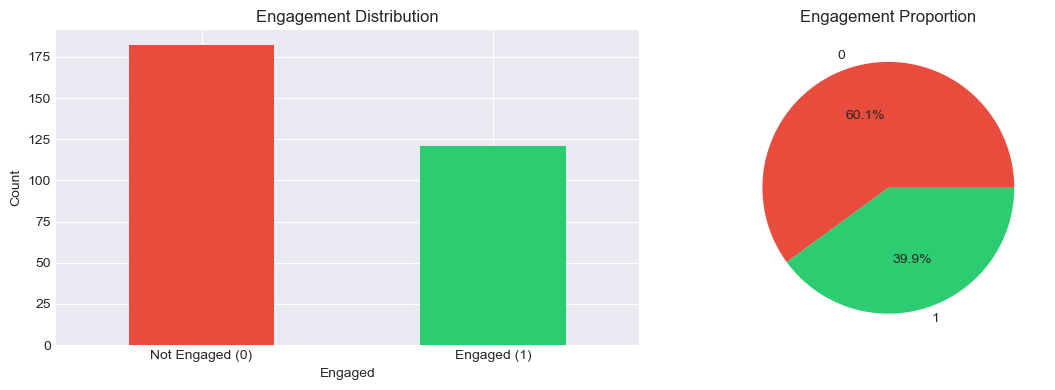

✓ Saved target distribution to MLflow


In [13]:
# Visualize target distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
clean_df['engaged'].value_counts().plot(kind='bar', ax=ax[0], color=['#e74c3c', '#2ecc71'])
ax[0].set_title('Engagement Distribution')
ax[0].set_xlabel('Engaged')
ax[0].set_ylabel('Count')
ax[0].set_xticklabels(['Not Engaged (0)', 'Engaged (1)'], rotation=0)

# Pie chart
clean_df['engaged'].value_counts().plot(kind='pie', ax=ax[1], autopct='%1.1f%%', colors=['#e74c3c', '#2ecc71'])
ax[1].set_title('Engagement Proportion')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

# Save figure as MLflow artifact
fig.savefig('/tmp/target_distribution.png', dpi=100, bbox_inches='tight')
mlflow.log_artifact('/tmp/target_distribution.png', 'visualizations')
print("✓ Saved target distribution to MLflow")

## 7. Save Cleaned Dataset

Save cleaned data for modeling (logged as MLflow artifact)

In [14]:
# Create output directory
os.makedirs("../data/processed", exist_ok=True)

# Save cleaned dataset
output_path = "../data/processed/linkedin_leads_clean.csv"
clean_df.to_csv(output_path, index=False)
print(f"✓ Saved cleaned dataset: {output_path}")
print(f"  Shape: {clean_df.shape}")
print(f"  Target column: 'engaged'")

# Log dataset as MLflow artifact
mlflow.log_artifact(output_path, "processed_data")

# Log final dataset summary
log_data_profile(clean_df, stage="final")

print("\n✓ Logged cleaned dataset to MLflow")

✓ Saved cleaned dataset: ../data/processed/linkedin_leads_clean.csv
  Shape: (303, 20)
  Target column: 'engaged'
✓ Logged final data profile to MLflow

✓ Logged cleaned dataset to MLflow


## 8. Summary & Next Steps

In [15]:
# Print summary
print("="*60)
print("DATA PREPARATION SUMMARY")
print("="*60)
print(f"Raw contacts: {len(raw_df)}")
print(f"Labeled contacts: {len(labeled_df)}")
print(f"Final dataset: {len(clean_df)} rows × {len(clean_df.columns)} columns")
print(f"\nTarget distribution:")
print(f"  Engaged (1): {(clean_df['engaged']==1).sum()} ({(clean_df['engaged']==1).mean():.1%})")
print(f"  Not Engaged (0): {(clean_df['engaged']==0).sum()} ({(clean_df['engaged']==0).mean():.1%})")
print(f"\nFeatures:")
print(f"  Numeric: {len(num_features)}")
print(f"  Categorical: {len(cat_features)}")
print(f"\nData quality:")
print(f"  Constant columns: {len(quality['constant_cols'])}")
print(f"  High missing columns: {len(quality['high_missing_cols'])}")
print(f"\nOutput:")
print(f"  File: {output_path}")
print(f"  MLflow Run: {mlflow.active_run().info.run_id}")
print(f"  MLflow UI: http://localhost:5000")
print("\n" + "="*60)
print("✓ Data preparation complete!")
print("Next: Train classifier in notebook 02")
print("="*60)

DATA PREPARATION SUMMARY
Raw contacts: 477
Labeled contacts: 303
Final dataset: 303 rows × 20 columns

Target distribution:
  Engaged (1): 121 (39.9%)
  Not Engaged (0): 182 (60.1%)

Features:
  Numeric: 3
  Categorical: 16

Data quality:
  Constant columns: 4
  High missing columns: 5

Output:
  File: ../data/processed/linkedin_leads_clean.csv
  MLflow Run: 5e2bb52c26b34470bbb1a7864a8f9eae
  MLflow UI: http://localhost:5000

✓ Data preparation complete!
Next: Train classifier in notebook 02


In [16]:
# End MLflow run
mlflow.end_run()
print("✓ MLflow run ended")
print(f"\nView results at: http://localhost:5000")

✓ MLflow run ended

View results at: http://localhost:5000


In [17]:
import mlflow
print(f"Tracking URI: {mlflow.get_tracking_uri()}")
print(f"Active experiment: {mlflow.get_experiment_by_name('linkedin-lead-scoring')}")
print(f"Last run ID: {mlflow.active_run().info.run_id if mlflow.active_run() else 'No active run'}")


Tracking URI: file:///Users/ghislaindelabie/Projets%20de%CC%81v/Formation%20OC/OC6%20-%20Initiez-vous%20au%20MLOps/oc6-linkedin-lead-scoring/mlruns
Active experiment: <Experiment: artifact_location='file:///Users/ghislaindelabie/Projets%20de%CC%81v/Formation%20OC/OC6%20-%20Initiez-vous%20au%20MLOps/oc6-linkedin-lead-scoring/mlruns/796258469850849262', creation_time=1765535092173, experiment_id='796258469850849262', last_update_time=1765535092173, lifecycle_stage='active', name='linkedin-lead-scoring', tags={}>
Last run ID: No active run
